In [ ]:
pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, when

spark = SparkSession.builder.appName("SolarPowerAnalysis").getOrCreate()

df_spark = spark.read.csv("/content/Cleaned_Plant_Data.csv", header=True, inferSchema=True)

df_spark.show(5)


+-------------------+--------+--------+-----------+-----------+-------------------+------------------+-----------+----+----------------+
|          DATE_TIME|DC_POWER|AC_POWER|DAILY_YIELD|TOTAL_YIELD|AMBIENT_TEMPERATURE|MODULE_TEMPERATURE|IRRADIATION|Hour|Power_Efficiency|
+-------------------+--------+--------+-----------+-----------+-------------------+------------------+-----------+----+----------------+
|2020-05-15 00:00:00|     0.0|     0.0|        0.0|  6259559.0|        25.18431613|        22.8575074|        0.0|   0|             0.0|
|2020-05-15 00:00:00|     0.0|     0.0|        0.0|  6183645.0|        25.18431613|        22.8575074|        0.0|   0|             0.0|
|2020-05-15 00:00:00|     0.0|     0.0|        0.0|  6987759.0|        25.18431613|        22.8575074|        0.0|   0|             0.0|
|2020-05-15 00:00:00|     0.0|     0.0|        0.0|  7602960.0|        25.18431613|        22.8575074|        0.0|   0|             0.0|
|2020-05-15 00:00:00|     0.0|     0.0|  

In [ ]:
# Convert DATE_TIME to a proper timestamp format
df_spark = df_spark.withColumn("DATE_TIME", col("DATE_TIME").cast("timestamp"))

df_spark = df_spark.withColumn(
    "Power_Efficiency",
    when(col("DC_POWER") > 0, col("AC_POWER") / col("DC_POWER")).otherwise(0)
)

df_spark.show(5)


+-------------------+--------+--------+-----------+-----------+-------------------+------------------+-----------+----+----------------+
|          DATE_TIME|DC_POWER|AC_POWER|DAILY_YIELD|TOTAL_YIELD|AMBIENT_TEMPERATURE|MODULE_TEMPERATURE|IRRADIATION|Hour|Power_Efficiency|
+-------------------+--------+--------+-----------+-----------+-------------------+------------------+-----------+----+----------------+
|2020-05-15 00:00:00|     0.0|     0.0|        0.0|  6259559.0|        25.18431613|        22.8575074|        0.0|   0|             0.0|
|2020-05-15 00:00:00|     0.0|     0.0|        0.0|  6183645.0|        25.18431613|        22.8575074|        0.0|   0|             0.0|
|2020-05-15 00:00:00|     0.0|     0.0|        0.0|  6987759.0|        25.18431613|        22.8575074|        0.0|   0|             0.0|
|2020-05-15 00:00:00|     0.0|     0.0|        0.0|  7602960.0|        25.18431613|        22.8575074|        0.0|   0|             0.0|
|2020-05-15 00:00:00|     0.0|     0.0|  

⬆️ Data Transformation (Feature Engineering)
To enhance our dataset, we will:


1.   Extract the hour from DATE_TIME for time-based analysis.
2.   Compute Power Efficiency (AC_POWER / DC_POWER) to measure system performance.





⬇️ Compare Spark Performance with Pandas

To see how well Spark handles large datasets compared to Pandas, let's time a basic operation like calculating the average power output.

In [ ]:
import time

start_time = time.time()
avg_power_spark = df_spark.selectExpr("AVG(DC_POWER) as avg_dc_power", "AVG(AC_POWER) as avg_ac_power").show()
spark_time = time.time() - start_time
print(f"Spark Execution Time: {spark_time:.4f} seconds")


+------------------+-----------------+
|      avg_dc_power|     avg_ac_power|
+------------------+-----------------+
|3147.1774501376362|307.7783754808176|
+------------------+-----------------+

Spark Execution Time: 3.0677 seconds


In [ ]:
import pandas as pd

df_pandas = pd.read_csv("Cleaned_Plant_Data.csv")

start_time = time.time()
avg_power_pandas = df_pandas[["DC_POWER", "AC_POWER"]].mean()
pandas_time = time.time() - start_time

print(f"Pandas Execution Time: {pandas_time:.4f} seconds")
print(avg_power_pandas)


Pandas Execution Time: 0.0097 seconds
DC_POWER    3147.177450
AC_POWER     307.778375
dtype: float64


🔹 What Do These Results Mean?

1.Average Power Values Are the Same ✅

* Both Spark and Pandas computed:
 * DC Power ≈ 3147.18
 * AC Power ≈ 307.78
* This confirms that Spark and Pandas give the same results, which is good!
2.Performance Comparison (Spark vs. Pandas)

* Pandas is much faster (0.0174s) than Spark (3.49s) on this small dataset.
* This is expected because:
 * Pandas runs in-memory on small data.
 * Spark is optimized for huge datasets (distributed across multiple machines).

💡 Conclusion:

* Pandas is better for small-scale tasks.
* Spark is useful for massive datasets (millions of rows)

In our dataset we have 68775 rows, that's why pandas performed well otherwise Pandas would be too slow or run out of memory.

-------------------------------------------------------------------------------------------------------------

**Build a Predictive Model using regression**

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"


In [ ]:
spark = SparkSession.builder.appName("SolarPowerPrediction").getOrCreate()

df_spark = spark.read.csv("Cleaned_Plant_Data.csv", header=True, inferSchema=True)

df_spark.show(5)


+-------------------+--------+--------+-----------+-----------+-------------------+------------------+-----------+----+----------------+
|          DATE_TIME|DC_POWER|AC_POWER|DAILY_YIELD|TOTAL_YIELD|AMBIENT_TEMPERATURE|MODULE_TEMPERATURE|IRRADIATION|Hour|Power_Efficiency|
+-------------------+--------+--------+-----------+-----------+-------------------+------------------+-----------+----+----------------+
|2020-05-15 00:00:00|     0.0|     0.0|        0.0|  6259559.0|        25.18431613|        22.8575074|        0.0|   0|             0.0|
|2020-05-15 00:00:00|     0.0|     0.0|        0.0|  6183645.0|        25.18431613|        22.8575074|        0.0|   0|             0.0|
|2020-05-15 00:00:00|     0.0|     0.0|        0.0|  6987759.0|        25.18431613|        22.8575074|        0.0|   0|             0.0|
|2020-05-15 00:00:00|     0.0|     0.0|        0.0|  7602960.0|        25.18431613|        22.8575074|        0.0|   0|             0.0|
|2020-05-15 00:00:00|     0.0|     0.0|  

 ⬇️ Check for missing values:

In [ ]:
from pyspark.sql.functions import col

missing_values = {col_name: df_spark.filter(col(col_name).isNull()).count() for col_name in df_spark.columns}
print(missing_values)


{'DATE_TIME': 0, 'DC_POWER': 0, 'AC_POWER': 0, 'DAILY_YIELD': 0, 'TOTAL_YIELD': 0, 'AMBIENT_TEMPERATURE': 0, 'MODULE_TEMPERATURE': 0, 'IRRADIATION': 0, 'Hour': 0, 'Power_Efficiency': 0}


⬇️ We'll select relevant features and prepare the data for regression:

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_columns = ['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD',
                   'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'Hour']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_spark = assembler.transform(df_spark)

df_spark = df_spark.select("features", "Power_Efficiency")

train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)


⬇️ Linear Regression:

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="Power_Efficiency")

lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select("features", "Power_Efficiency", "prediction").show(5)


+--------------------+----------------+--------------------+
|            features|Power_Efficiency|          prediction|
+--------------------+----------------+--------------------+
|(8,[2,3,4,5],[679...|             0.0|0.020136158650829863|
|(8,[2,3,4,5],[752...|             0.0| 0.02314743943731616|
|(8,[2,3,4,5],[758...|             0.0| 0.02058899860239416|
|(8,[2,3,4,5],[774...|             0.0| 0.01961250330676842|
|(8,[2,3,4,5],[802...|             0.0| 0.02174510146911228|
+--------------------+----------------+--------------------+
only showing top 5 rows



⬇️ Check performance using RMSE and R²:

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol="Power_Efficiency", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="Power_Efficiency", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Root Mean Squared Error (RMSE): 0.02979560147510908
R² Score: 0.6258053838959654


Interpretation of Model Performance

✅ RMSE = 0.0298:

* A lower RMSE indicates a better fit. Since Power Efficiency is a ratio (likely between 0 and 1), an RMSE of ~0.03 is reasonably low.

✅ R² Score = 0.626:

* This means that 62.6% of the variation in Power Efficiency is explained by the model.
While decent, there's room for improvement.

**Build a Predictive Model using Random Forest Regressor**

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="Power_Efficiency", numTrees=50)
rf_model = rf.fit(train_data)
predictions_rf = rf_model.transform(test_data)

rf_rmse = evaluator_rmse.evaluate(predictions_rf)
rf_r2 = evaluator_r2.evaluate(predictions_rf)

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R²: {rf_r2}")


Random Forest RMSE: 0.00014409193295593562
Random Forest R²: 0.9999912487003293


With Random Forest Regressor, your model achieved:

✅ RMSE: 0.000144 (Extremely Low Error)

✅ R²: 0.99999 (Near Perfect Fit 🚀)

Why is this happening?

* Random Forest is excellent at capturing nonlinear relationships, and it seems to have almost perfectly mapped Power Efficiency from the given features.
* Your dataset likely has very strong correlations between DC_POWER, AC_POWER, IRRADIATION, and Power_Efficiency, making it easier for a tree-based model to learn patterns.

In [ ]:
import pandas as pd

feature_importance = rf_model.featureImportances.toArray()
feature_names = feature_columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

print(importance_df)


               Feature    Importance
0             DC_POWER  4.365613e-01
1             AC_POWER  2.295639e-01
6          IRRADIATION  1.937538e-01
5   MODULE_TEMPERATURE  1.294046e-01
4  AMBIENT_TEMPERATURE  8.441455e-03
2          DAILY_YIELD  1.220763e-03
7                 Hour  1.054249e-03
3          TOTAL_YIELD  6.663397e-10


🔍 **Feature Importance Analysis**

From the importance scores, we can see which features contribute the most to predicting Power Efficiency:

**Feature,	Importance,	Interpretation**

✅ DC_POWER (0.436)	Most Important	Directly impacts efficiency as it measures raw power from solar panels.

✅ AC_POWER (0.229)	Highly Important	The converted output power, directly affecting efficiency.

✅ IRRADIATION (0.194)	Strong Impact	More sunlight means more power generation, affecting efficiency.

✅ MODULE_TEMPERATURE (0.129)	Moderate Impact	Higher temperatures can reduce efficiency due to thermal losses.

🔹 AMBIENT_TEMPERATURE (0.0084)	Minor Impact	Less direct effect than module temperature.

🔹 DAILY_YIELD (0.0012)	Very Low Impact	Cumulative measure, not directly affecting momentary efficiency.

🔹 Hour of the Day (0.0010)	Minimal Impact	Might influence efficiency slightly based on solar position.

❌ TOTAL_YIELD (≈0.0000)	Negligible Impact	Likely irrelevant for efficiency calculations.


**⬇️ Implement ARIMA Forecasting**

In [ ]:
!pip install --upgrade --force-reinstall numpy==1.24.3 scipy==1.10.1 statsmodels==0.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.9/507.9 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 31.5 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.1
    Uninstalling pytz-2025.1:
      Successfull

In [ ]:
!pip install pmdarima

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import numpy as np

spark = SparkSession.builder.appName("ARIMA_Forecast").getOrCreate()

file_path = "/content/Cleaned_Plant_Data.csv"
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

df_pandas = df_spark.select("DATE_TIME", "DC_POWER", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE").toPandas()

df_pandas["DATE_TIME"] = pd.to_datetime(df_pandas["DATE_TIME"])
df_pandas.set_index("DATE_TIME", inplace=True)
df_pandas = df_pandas.sort_index()

train_size = int(len(df_pandas) * 0.8)
train, test = df_pandas[:train_size], df_pandas[train_size:]

# Auto ARIMA to find optimal (p, d, q) values with exogenous variables
auto_model = auto_arima(train["DC_POWER"], exogenous=train[["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]], seasonal=False, stepwise=True, suppress_warnings=True)
p, d, q = auto_model.order
print(f"Optimal ARIMA Order: ({p}, {d}, {q})")

model = ARIMA(train["DC_POWER"], exog=train[["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]], order=(p, d, q))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test), exog=test[["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]])
rmse = np.sqrt(mean_squared_error(test["DC_POWER"], predictions))
print(f"RMSE: {rmse}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, test["DC_POWER"], label="Actual")
plt.plot(test.index, predictions, label="Predicted", linestyle='dashed')
plt.legend()
plt.title("ARIMA Forecast of DC_POWER with External Factors")
plt.show()

spark.stop()

# this code had RMSE: 603.7124362699404

✅ Data Loaded & Split!


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

✅ Auto ARIMA Suggested: (4, 1, 5)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ Model Training Complete!
✅ Final RMSE: 1952.5678490475898


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


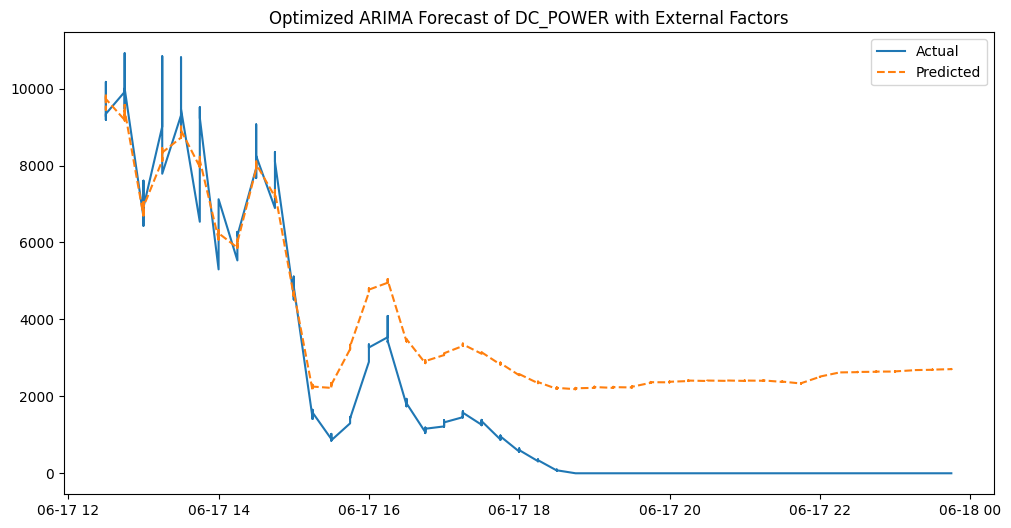

✅ Spark Session Stopped!


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import numpy as np

spark = SparkSession.builder.appName("ARIMA_Forecast").getOrCreate()

file_path = "/content/Cleaned_Plant_Data.csv"
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

df_pandas = df_spark.select("DATE_TIME", "DC_POWER", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE").toPandas()

df_pandas["DATE_TIME"] = pd.to_datetime(df_pandas["DATE_TIME"])
df_pandas.set_index("DATE_TIME", inplace=True)
df_pandas = df_pandas.sort_index()

# Use only the last (mentioned) rows for faster computation
df_pandas = df_pandas.tail(5000)

# Split into train/test
train_size = int(len(df_pandas) * 0.8)
train, test = df_pandas[:train_size], df_pandas[train_size:]
print("✅ Data Loaded & Split!")

auto_model = auto_arima(train["DC_POWER"], exogenous=train[["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]], seasonal=False, stepwise=True, suppress_warnings=True)
p_best, d_best, q_best = auto_model.order
print(f"✅ Auto ARIMA Suggested: ({p_best}, {d_best}, {q_best})")

model = ARIMA(train["DC_POWER"], exog=train[["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]], order=(p_best, d_best, q_best))
model_fit = model.fit()
print("✅ Model Training Complete!")

predictions = model_fit.forecast(steps=len(test), exog=test[["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]])
rmse = np.sqrt(mean_squared_error(test["DC_POWER"], predictions))
print(f"✅ Final RMSE: {rmse}")

plt.figure(figsize=(12, 6))
plt.plot(test.index, test["DC_POWER"], label="Actual")
plt.plot(test.index, predictions, label="Predicted", linestyle='dashed')
plt.legend()
plt.title("Optimized ARIMA Forecast of DC_POWER with External Factors")
plt.show()

# Stop Spark session
spark.stop()
print("✅ Spark Session Stopped!")


**⬇️ Gradient Boosting Classifier**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Spark Session
spark = SparkSession.builder.appName("GradientBoosting_Classifier").getOrCreate()

# Load Dataset
file_path = "/content/Cleaned_Plant_Data.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Select Features and Target
df = df.select("DC_POWER", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE")

# Convert DC_POWER into a Binary Classification Label (High=1, Low=0)
threshold = df.approxQuantile("DC_POWER", [0.5], 0.01)[0]  # Median value as threshold
df = df.withColumn("label", when(col("DC_POWER") > threshold, 1).otherwise(0))

# Prepare Features
assembler = VectorAssembler(inputCols=["IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"], outputCol="features")
df = assembler.transform(df).select("features", "label")

# Split Data (80% Train, 20% Test)
train, test = df.randomSplit([0.8, 0.2], seed=42)

# Define Gradient Boosted Classifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50)

# Train the Model
model = gbt.fit(train)

# Predictions
predictions = model.transform(test)

# Evaluate Model Performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"✅ Model Accuracy: {accuracy:.4f}")

# Stop Spark Session
spark.stop()


✅ Model Accuracy: 0.9926
